<a href="https://colab.research.google.com/github/Alejix/DataEngineering/blob/main/Tratamiento_Datos_Nulos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PIP

In [ ]:
!pip install nhanes
!pip install pyjanitor
!pip install missingno
!pip install pyreadr
!pip install session_info
!pip install UpSetPlot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.3/171.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00
  Created wheel for session_info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=dd60731bb65bbbd1d9c1399f88193e2097f30269169d562fcc808cc5ae89d567
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session_info
  Preparing metadata (setup.py) ... done
  Created wheel for UpSetPlot: filename=UpSetPlot-0.8.0-py3-none-any.whl size=23527 sha256=8901a98fa09bd6c41dbe137279318788c66572ff7cdab8290b9e9adbe1e899ee
  Stored in directory: /root/.cache/pip/wheels/e1/4d/34/4180be8c6882c7fb6d36dd787495d5ade498fe16113b918611
Successfully built UpSetPlot


#Importar librerías

In [ ]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sb
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn import set_config

from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import chi2

import warnings
warnings.filterwarnings('ignore')

# Cargar los datos


In [ ]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year = '2017-2018').clean_names(case_type = 'snake')
nhanes_raw_df.shape

(8366, 197)

In [ ]:
nhanes_selected = nhanes_raw_df.select_columns('general_health_condition',
                            'how_healthy_is_the_diet',
                            'have_serious_difficulty_hearing',
                            'have_serious_difficulty_seeing',
                            'have_serious_difficulty_concentrating',
                            'have_serious_difficulty_walking',
                            'total_sugars_gm_dr2_tot',
                            'total_fat_gm_dr2_tot',
                            'weight_kg',
                            'gender',
                            'age_in_years_at_screening',
                            'marital_status')
nhanes_selected

,general_health_condition,how_healthy_is_the_diet,have_serious_difficulty_hearing,have_serious_difficulty_seeing,have_serious_difficulty_concentrating,have_serious_difficulty_walking,total_sugars_gm_dr2_tot,total_fat_gm_dr2_tot,weight_kg,gender,age_in_years_at_screening,marital_status
SEQN,,,,,,,,,,,,
93703.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,13.7,Female,2.0,NaN
93704.0,NaN,NaN,0.0,0.0,NaN,NaN,134.37,37.02,13.9,Male,2.0,NaN
93705.0,Good,Good,0.0,0.0,0.0,0.0,43.04,55.19,79.5,Female,66.0,Divorced
93706.0,Very good,Very good,0.0,0.0,0.0,0.0,NaN,NaN,66.3,Male,18.0,NaN
93707.0,Good,NaN,0.0,0.0,0.0,0.0,85.81,93.98,45.4,Male,13.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,Excellent,0.0,0.0,0.0,0.0,52.84,23.35,49.0,Female,70.0,Married
102953.0,Fair or,Poor,0.0,0.0,0.0,0.0,NaN,NaN,97.4,Male,42.0,Separated
102954.0,Good,Good,0.0,0.0,0.0,0.0,87.58,84.05,69.1,Female,41.0,Never married


# 1. Explorar de forma general los datos

In [ ]:
nhanes_selected.info() #Ver tipos de datos y cantidad de datos

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8366 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   general_health_condition               5964 non-null   object 
 1   how_healthy_is_the_diet                5826 non-null   object 
 2   have_serious_difficulty_hearing        8365 non-null   float64
 3   have_serious_difficulty_seeing         8365 non-null   float64
 4   have_serious_difficulty_concentrating  7595 non-null   float64
 5   have_serious_difficulty_walking        7599 non-null   float64
 6   total_sugars_gm_dr2_tot                6323 non-null   float64
 7   total_fat_gm_dr2_tot                   6323 non-null   float64
 8   weight_kg                              8242 non-null   float64
 9   gender                                 8366 non-null   object 
 10  age_in_years_at_screening              8366 non-null   float

## Descripción de las variables númericas

In [ ]:
nhanes_selected.describe()

,have_serious_difficulty_hearing,have_serious_difficulty_seeing,have_serious_difficulty_concentrating,have_serious_difficulty_walking,total_sugars_gm_dr2_tot,total_fat_gm_dr2_tot,weight_kg,age_in_years_at_screening
count,8365.000000,8365.000000,7595.000000,7599.000000,6.323000e+03,6.323000e+03,8242.000000,8366.000000
mean,0.062762,0.052481,0.117972,0.122911,9.415974e+01,7.346473e+01,67.499260,35.830026
std,0.242548,0.223007,0.322597,0.328357,6.454107e+01,4.308108e+01,31.377152,24.905061
min,0.000000,0.000000,0.000000,0.000000,5.397605e-79,5.397605e-79,8.300000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,5.134500e+01,4.389500e+01,48.700000,12.000000
50%,0.000000,0.000000,0.000000,0.000000,8.178000e+01,6.538000e+01,69.200000,33.000000
75%,0.000000,0.000000,0.000000,0.000000,1.208450e+02,9.371500e+01,86.500000,59.000000
max,1.000000,1.000000,1.000000,1.000000,9.032000e+02,4.877300e+02,242.600000,80.000000


Podemos observar que todas las variables have_serious son categoricas en vez de númericas, entonces las transformamos.

In [ ]:
# converir a object las variables have_serious (deben ser object y no strings porque perderíamos los valores nulos)
nhanes_selected['have_serious_difficulty_hearing'] = nhanes_selected['have_serious_difficulty_hearing'].astype('object')
nhanes_selected['have_serious_difficulty_seeing'] = nhanes_selected['have_serious_difficulty_seeing'].astype('object')
nhanes_selected['have_serious_difficulty_concentrating'] = nhanes_selected['have_serious_difficulty_concentrating'].astype('object')
nhanes_selected['have_serious_difficulty_walking'] = nhanes_selected['have_serious_difficulty_walking'].astype('object')

In [ ]:
nhanes_selected.describe()

,total_sugars_gm_dr2_tot,total_fat_gm_dr2_tot,weight_kg,age_in_years_at_screening
count,6.323000e+03,6.323000e+03,8242.000000,8366.000000
mean,9.415974e+01,7.346473e+01,67.499260,35.830026
std,6.454107e+01,4.308108e+01,31.377152,24.905061
min,5.397605e-79,5.397605e-79,8.300000,1.000000
25%,5.134500e+01,4.389500e+01,48.700000,12.000000
50%,8.178000e+01,6.538000e+01,69.200000,33.000000
75%,1.208450e+02,9.371500e+01,86.500000,59.000000
max,9.032000e+02,4.877300e+02,242.600000,80.000000


## Descripción de las variables categóricas

In [ ]:
nhanes_selected.describe(include = 'object')

,general_health_condition,how_healthy_is_the_diet,have_serious_difficulty_hearing,have_serious_difficulty_seeing,have_serious_difficulty_concentrating,have_serious_difficulty_walking,gender,marital_status
count,5964,5826,8365.0,8365.0,7595.0,7599.0,8366,5260
unique,5,5,2.0,2.0,2.0,2.0,2,6
top,Good,Good,0.0,0.0,0.0,0.0,Female,Married
freq,2454,2283,7840.0,7926.0,6699.0,6665.0,4272,2616


In [ ]:
nhanes_selected.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8366 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   general_health_condition               5964 non-null   object 
 1   how_healthy_is_the_diet                5826 non-null   object 
 2   have_serious_difficulty_hearing        8365 non-null   object 
 3   have_serious_difficulty_seeing         8365 non-null   object 
 4   have_serious_difficulty_concentrating  7595 non-null   object 
 5   have_serious_difficulty_walking        7599 non-null   object 
 6   total_sugars_gm_dr2_tot                6323 non-null   float64
 7   total_fat_gm_dr2_tot                   6323 non-null   float64
 8   weight_kg                              8242 non-null   float64
 9   gender                                 8366 non-null   object 
 10  age_in_years_at_screening              8366 non-null   float

## ¿Hay datos nulos en las variables?

In [ ]:
nhanes_selected.isnull().any()

general_health_condition                  True
how_healthy_is_the_diet                   True
have_serious_difficulty_hearing           True
have_serious_difficulty_seeing            True
have_serious_difficulty_concentrating     True
have_serious_difficulty_walking           True
total_sugars_gm_dr2_tot                   True
total_fat_gm_dr2_tot                      True
weight_kg                                 True
gender                                   False
age_in_years_at_screening                False
marital_status                            True
dtype: bool

## ¿Cuántos nulos hay por variable?

In [ ]:
nhanes_selected.isnull().sum()

general_health_condition                 2402
how_healthy_is_the_diet                  2540
have_serious_difficulty_hearing             1
have_serious_difficulty_seeing              1
have_serious_difficulty_concentrating     771
have_serious_difficulty_walking           767
total_sugars_gm_dr2_tot                  2043
total_fat_gm_dr2_tot                     2043
weight_kg                                 124
gender                                      0
age_in_years_at_screening                   0
marital_status                           3106
dtype: int64

## Graficos

### Univariado

In [ ]:
plt.style.use("ggplot") #Para que los graficos queden mas bonitox
numerical = [['total_sugars_gm_dr2_tot', 'total_fat_gm_dr2_tot'], ['weight_kg', 'age_in_years_at_screening']]
categorical = [['have_serious_difficulty_hearing', 'have_serious_difficulty_seeing', 'have_serious_difficulty_concentrating', 'have_serious_difficulty_walking'],
               ['general_health_condition', 'how_healthy_is_the_diet', 'gender', 'marital_status']]
cords = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2]]
cords2 = [[0,0],[0,1],[0,2],[0,3],[0,4],[1,0],[1,1],[1,2],[1,3],[1,4],[2,0],[2,1],[2,2],[2,3],[2,4],[3,0],[3,1],[3,2],[3,3],[3,4],[4,0],[4,1],[4,2],[4,3],[4,4],[5,0],[5,1],[5,2],[5,3],[5,4]]

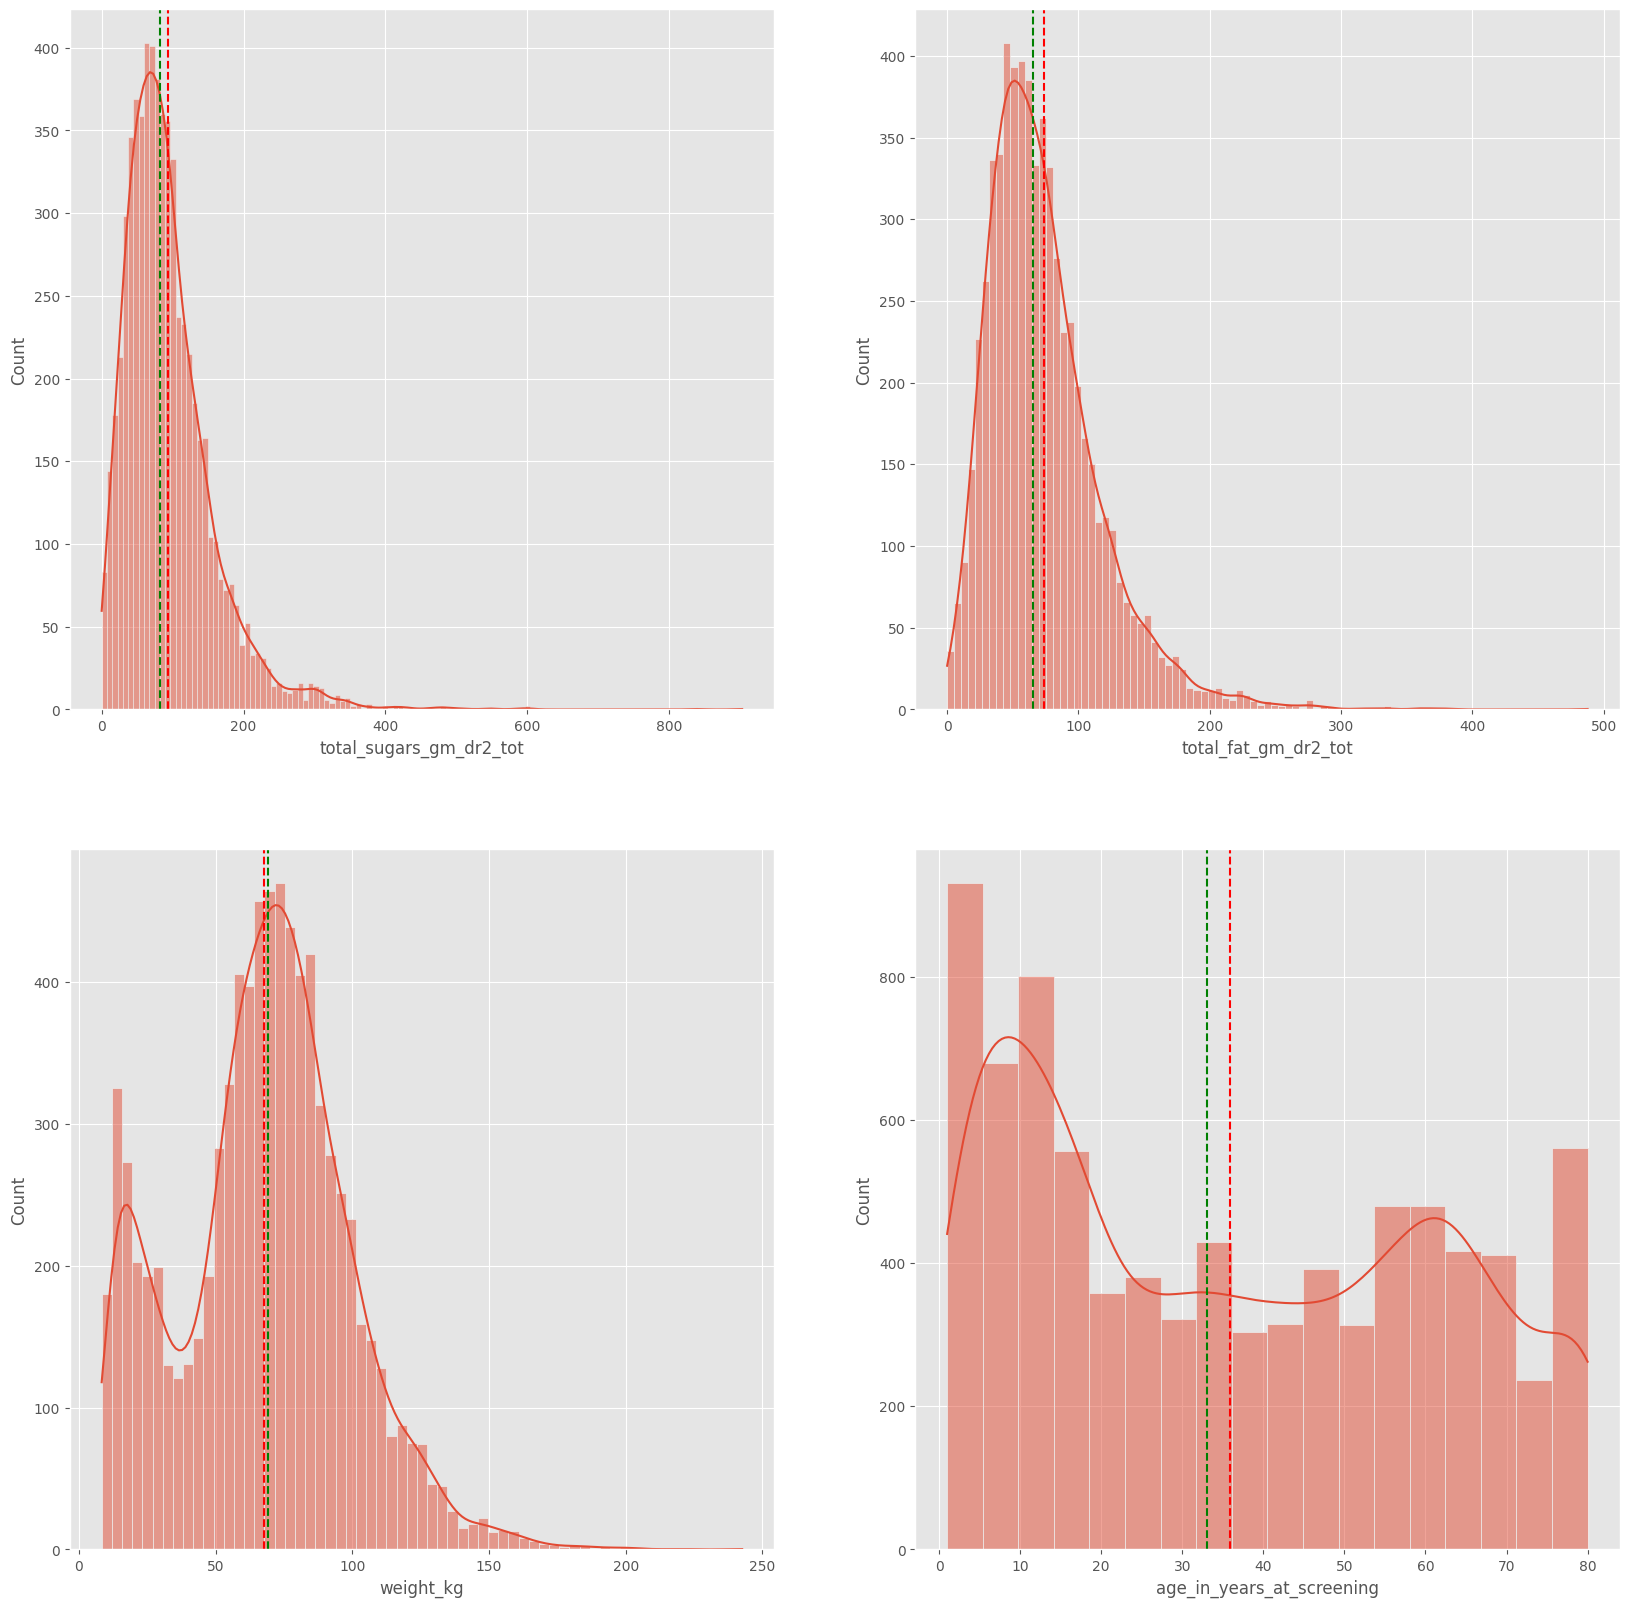

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for i in range(2):
  for j in range(2):
    sb.histplot(data = nhanes_selected, x=numerical[i][j], kde=True, ax=ax[i,j])
    ax[i,j].axvline(x=nhanes_selected[numerical[i][j]].mean(), color='red', linestyle='dashed')
    ax[i,j].axvline(x=nhanes_selected[numerical[i][j]].median(), color='green', linestyle='dashed')
plt.show()

Las variables numéricas presentan media y mediana similares en todos los casos. Una gran parte del estudio son personas jóvenes. Esto podría representar la probabilidad de nulos

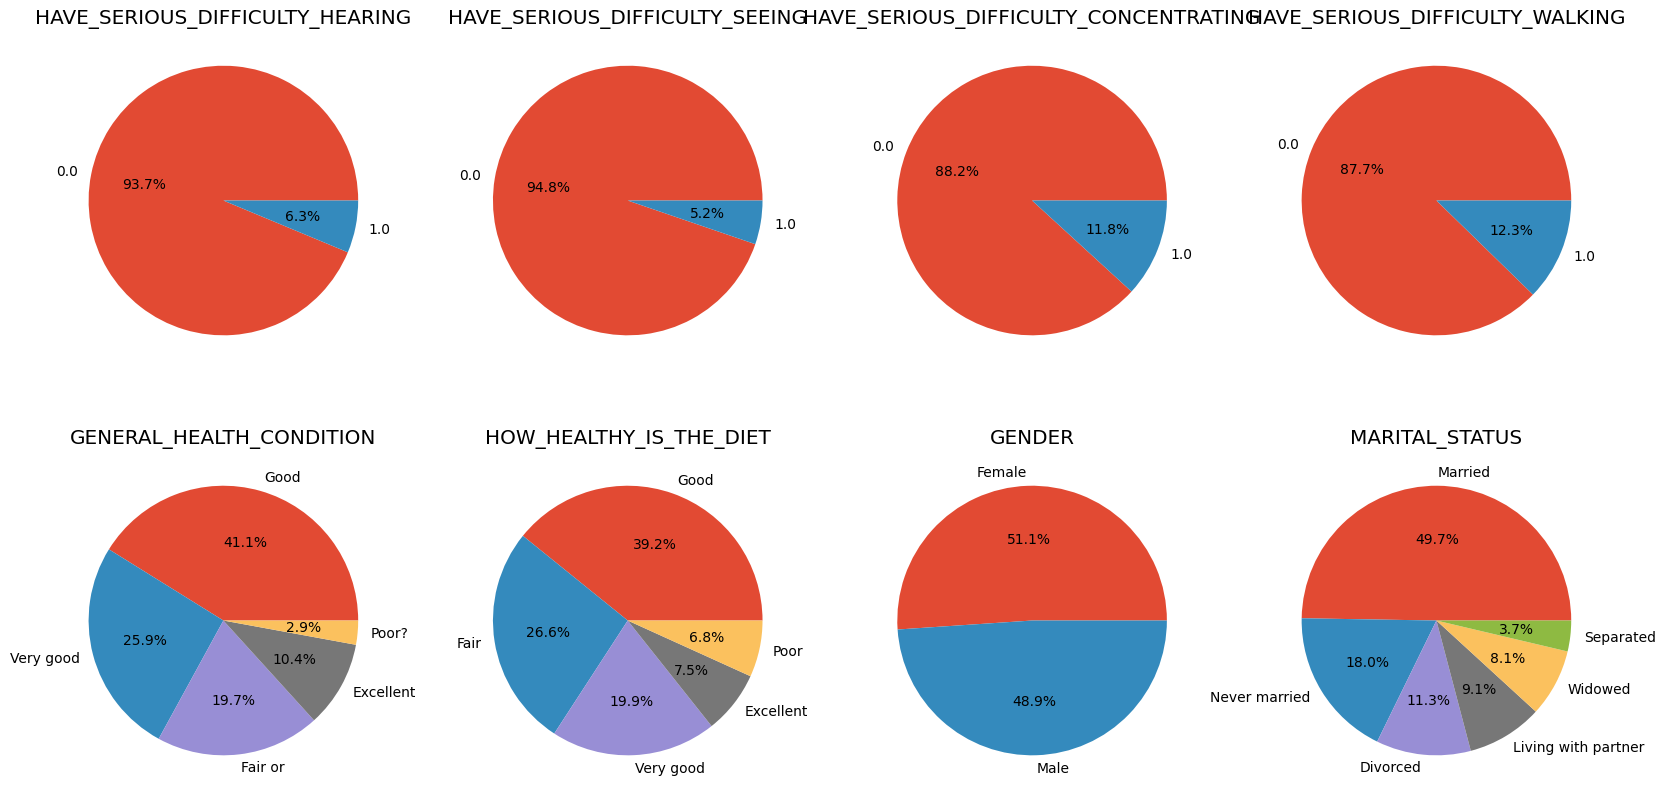

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range (2):
  for j in range(4):
    ax[i,j].pie(x = nhanes_selected[categorical[i][j]].value_counts(), labels=nhanes_selected[categorical[i][j]].value_counts().index, autopct='%0.1f%%')
    ax[i,j].set_title(categorical[i][j].upper())
plt.show()

Podemos observar que más o menos la mitad de participantes son mujeres casadas o viudas.

### Multivariado

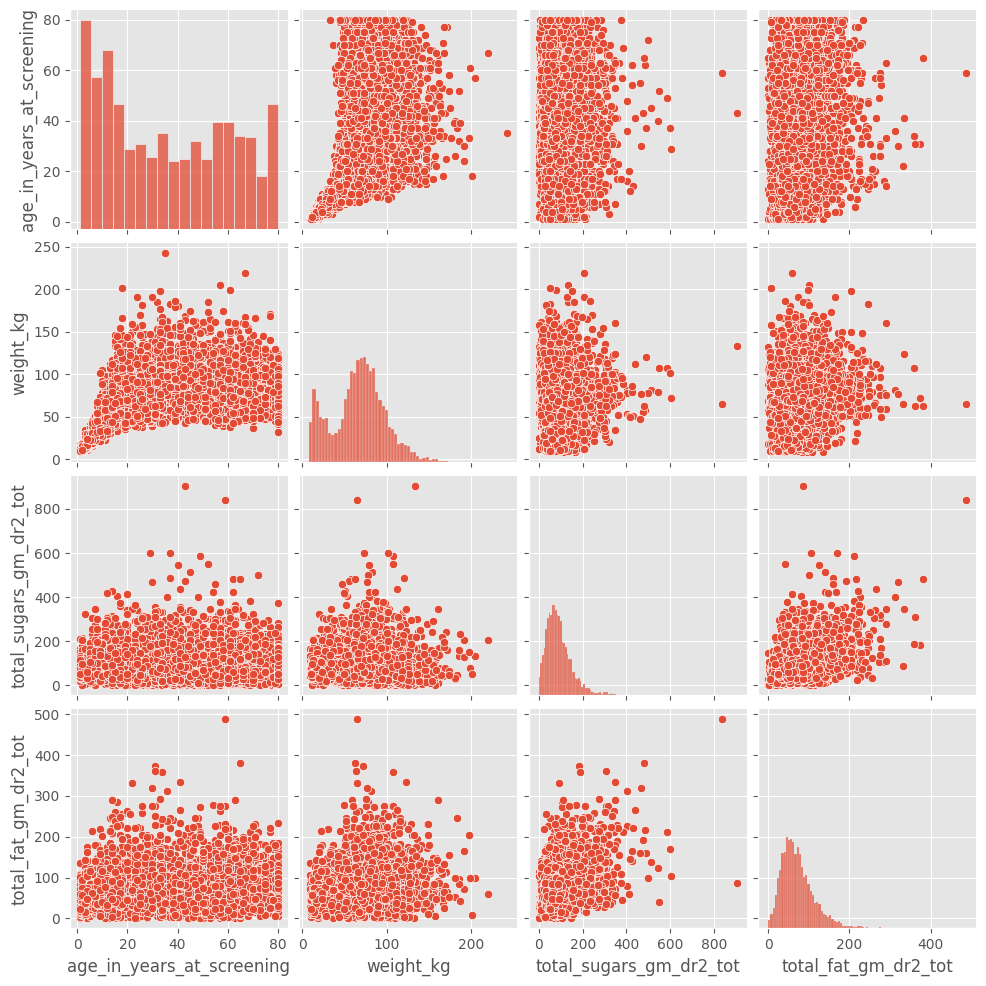

In [ ]:
sb.pairplot(data = nhanes_selected[['age_in_years_at_screening','weight_kg', 'total_sugars_gm_dr2_tot','total_fat_gm_dr2_tot']])
plt.show()

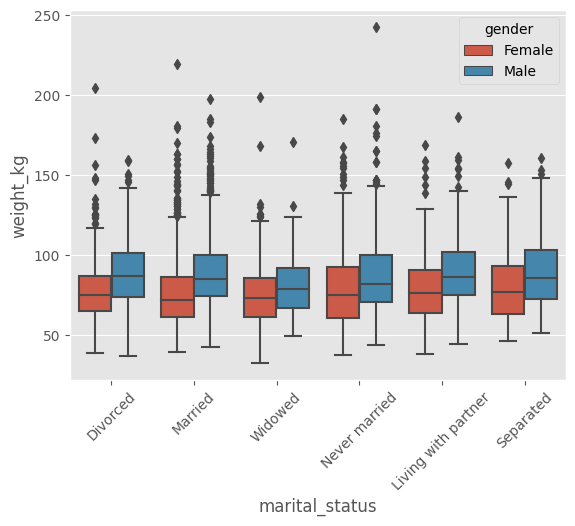

In [ ]:
sb.boxplot(data=nhanes_selected, x='marital_status', y='weight_kg', hue='gender')
plt.xticks(rotation = 45)
plt.show()

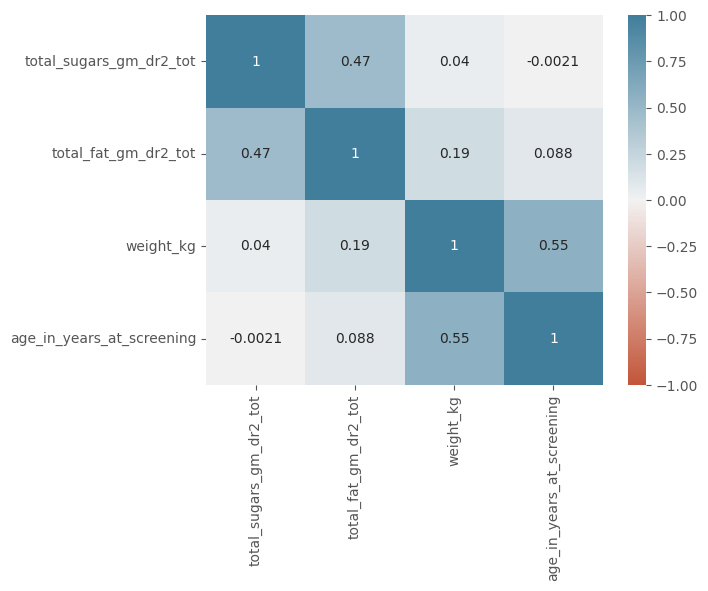

In [ ]:
sb.heatmap(data = nhanes_selected.corr(numeric_only=True), center = 0,
           vmax=1, vmin=-1, annot=True, cmap = sb.diverging_palette(20,230, as_cmap=True))
plt.show()

Hay una correlación positiva moderada entre el peso en kilogramos y la edad como es de esperarse.
Además hay una correlación positiva débil entre el total de grasa y el total de azucar en la dieta DR2

# 2. Exploración de datos nulos

In [ ]:
print(nhanes_selected.shape)
nhanes_selected.isnull().sum()

(8366, 12)


general_health_condition                 2402
how_healthy_is_the_diet                  2540
have_serious_difficulty_hearing             1
have_serious_difficulty_seeing              1
have_serious_difficulty_concentrating     771
have_serious_difficulty_walking           767
total_sugars_gm_dr2_tot                  2043
total_fat_gm_dr2_tot                     2043
weight_kg                                 124
gender                                      0
age_in_years_at_screening                   0
marital_status                           3106
dtype: int64

Podemos observar que la variable con mayor cantidad de datos nulos es marital_status. Probablmente debido a que la gente prefiere no responder a la pregunta o porque son la población más joven.

In [ ]:
# nhanes_drop_df = nhanes_selected.dropna(subset = ['have_serious_difficulty_hearing', 'have_serious_difficulty_seeing'], how='any')

## Proporción de datos nulos por columna

general_health_condition                 0.287115
how_healthy_is_the_diet                  0.303610
have_serious_difficulty_hearing          0.000120
have_serious_difficulty_seeing           0.000120
have_serious_difficulty_concentrating    0.092159
have_serious_difficulty_walking          0.091681
total_sugars_gm_dr2_tot                  0.244203
total_fat_gm_dr2_tot                     0.244203
weight_kg                                0.014822
gender                                   0.000000
age_in_years_at_screening                0.000000
marital_status                           0.371265
dtype: float64


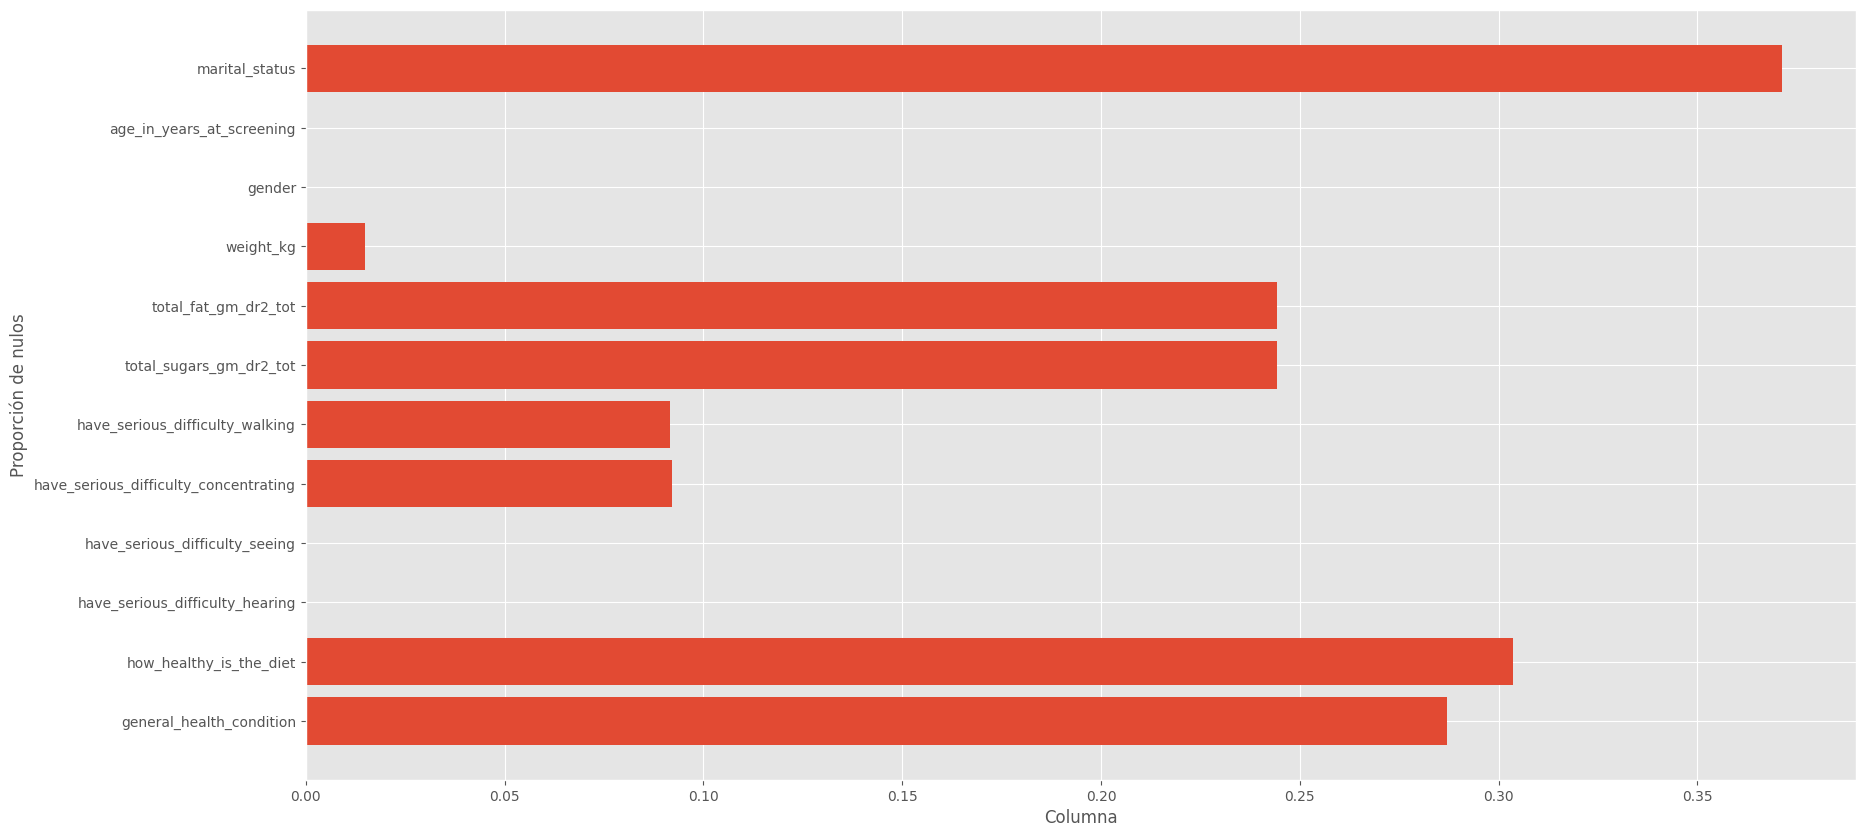

In [ ]:
null_proportions = nhanes_selected.isnull().mean()
plt.figure(figsize=(20,10))
plt.barh(nhanes_selected.columns, null_proportions)
plt.xlabel("Columna")
plt.ylabel("Proporción de nulos")
print(null_proportions)

Lo mismo podemos decir de lo saludable de la dieta y la condición de salud general. La gente opta por no responder a la pregunta por pudor, vergüenza o por ignorancia.

## Completitud de datos por columna

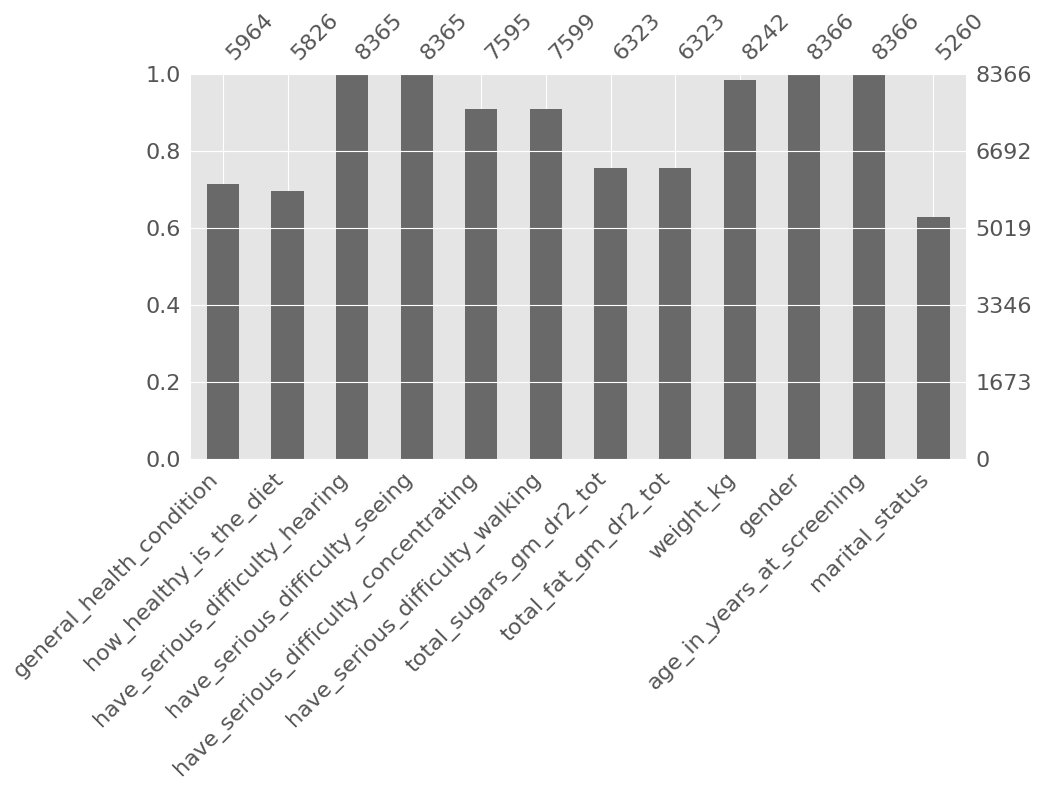

In [ ]:
missingno.bar(nhanes_selected, figsize=(10,5))
plt.show()

Todas las variables poseen una completitud mayor al 60%.

## Ubicación de datos nulos

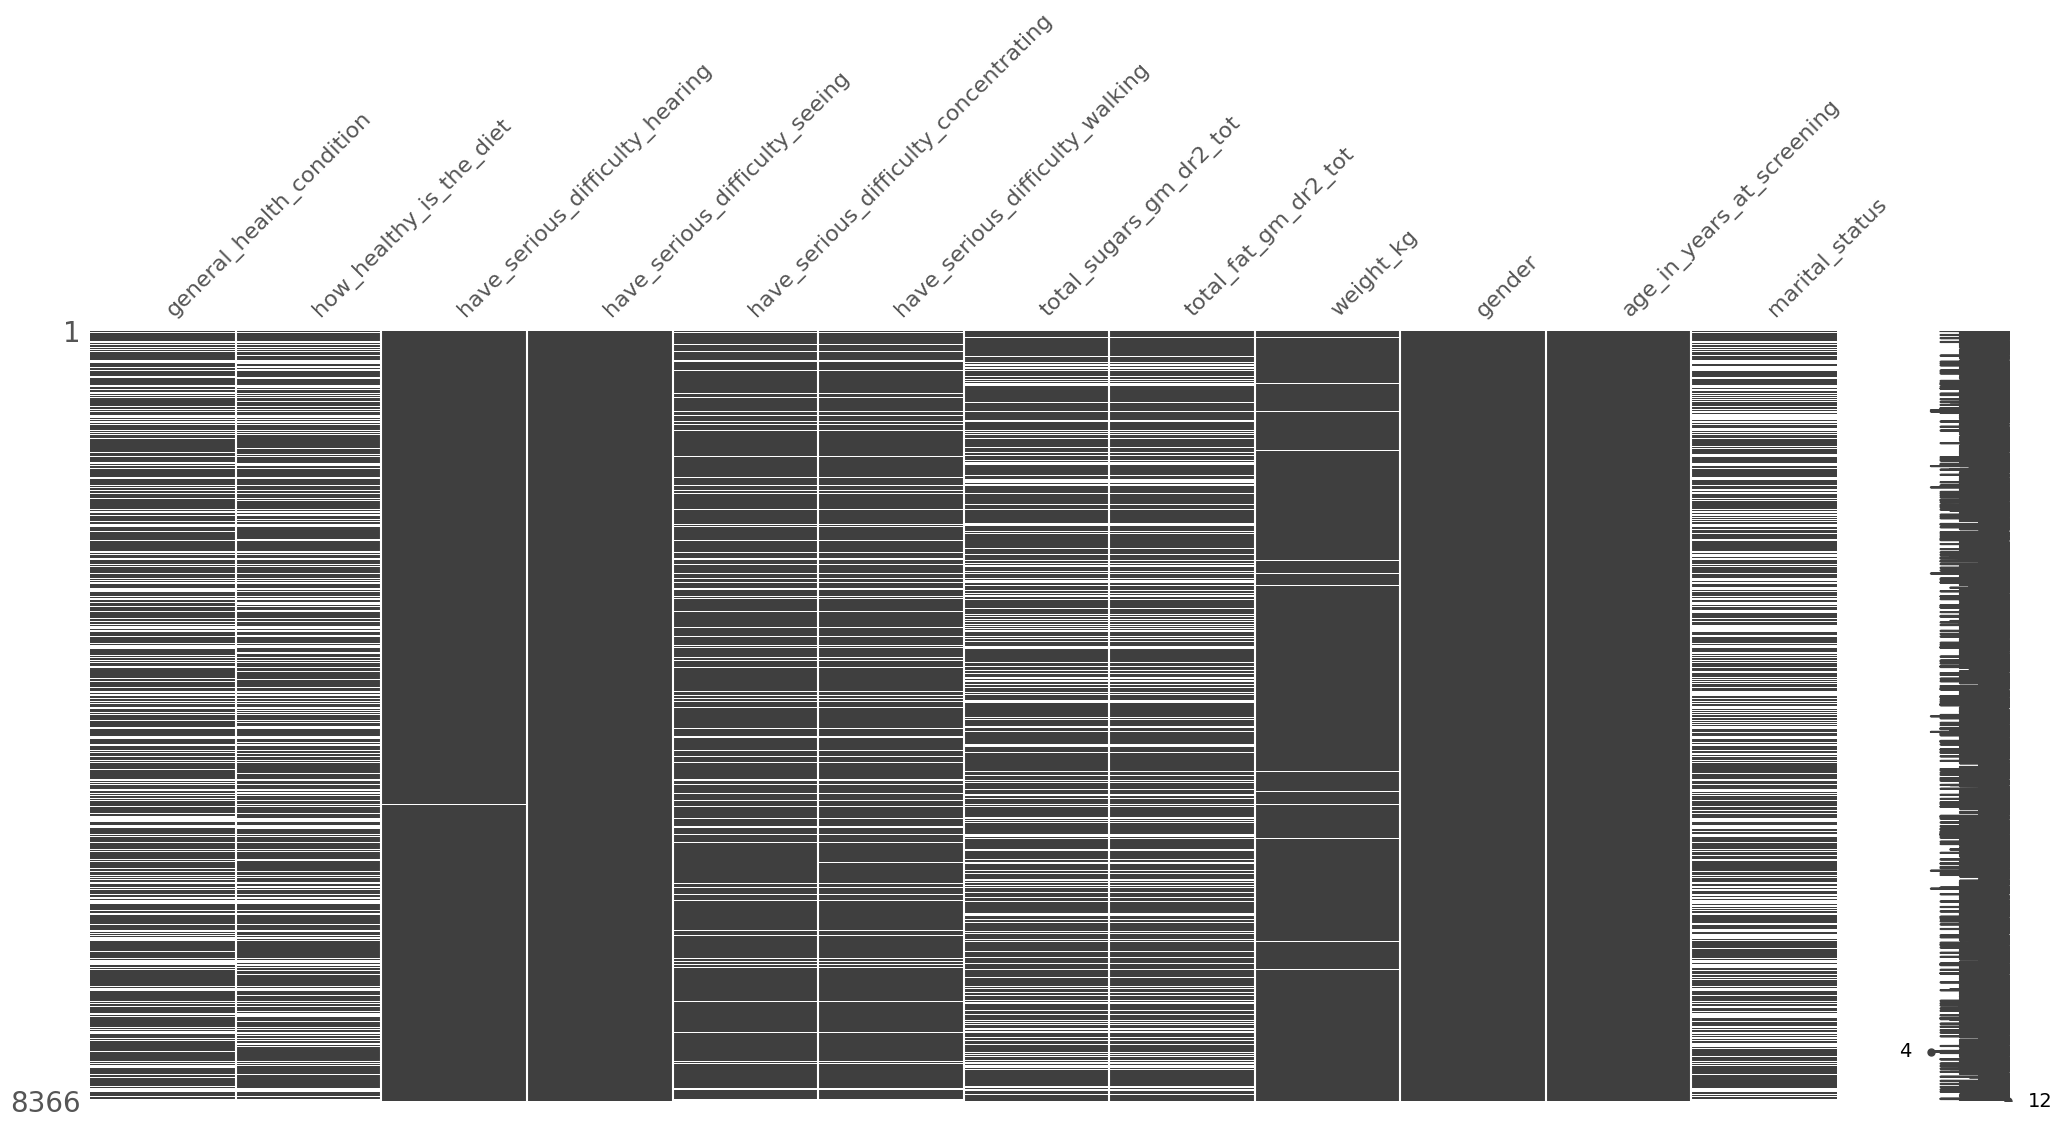

In [ ]:
missingno.matrix(nhanes_selected)
plt.show()
# 4 es el mayor número de datos faltantes en una fila. 12 es la fila con mayor cantidad de datos no nulos

## Correlación de datos nulos

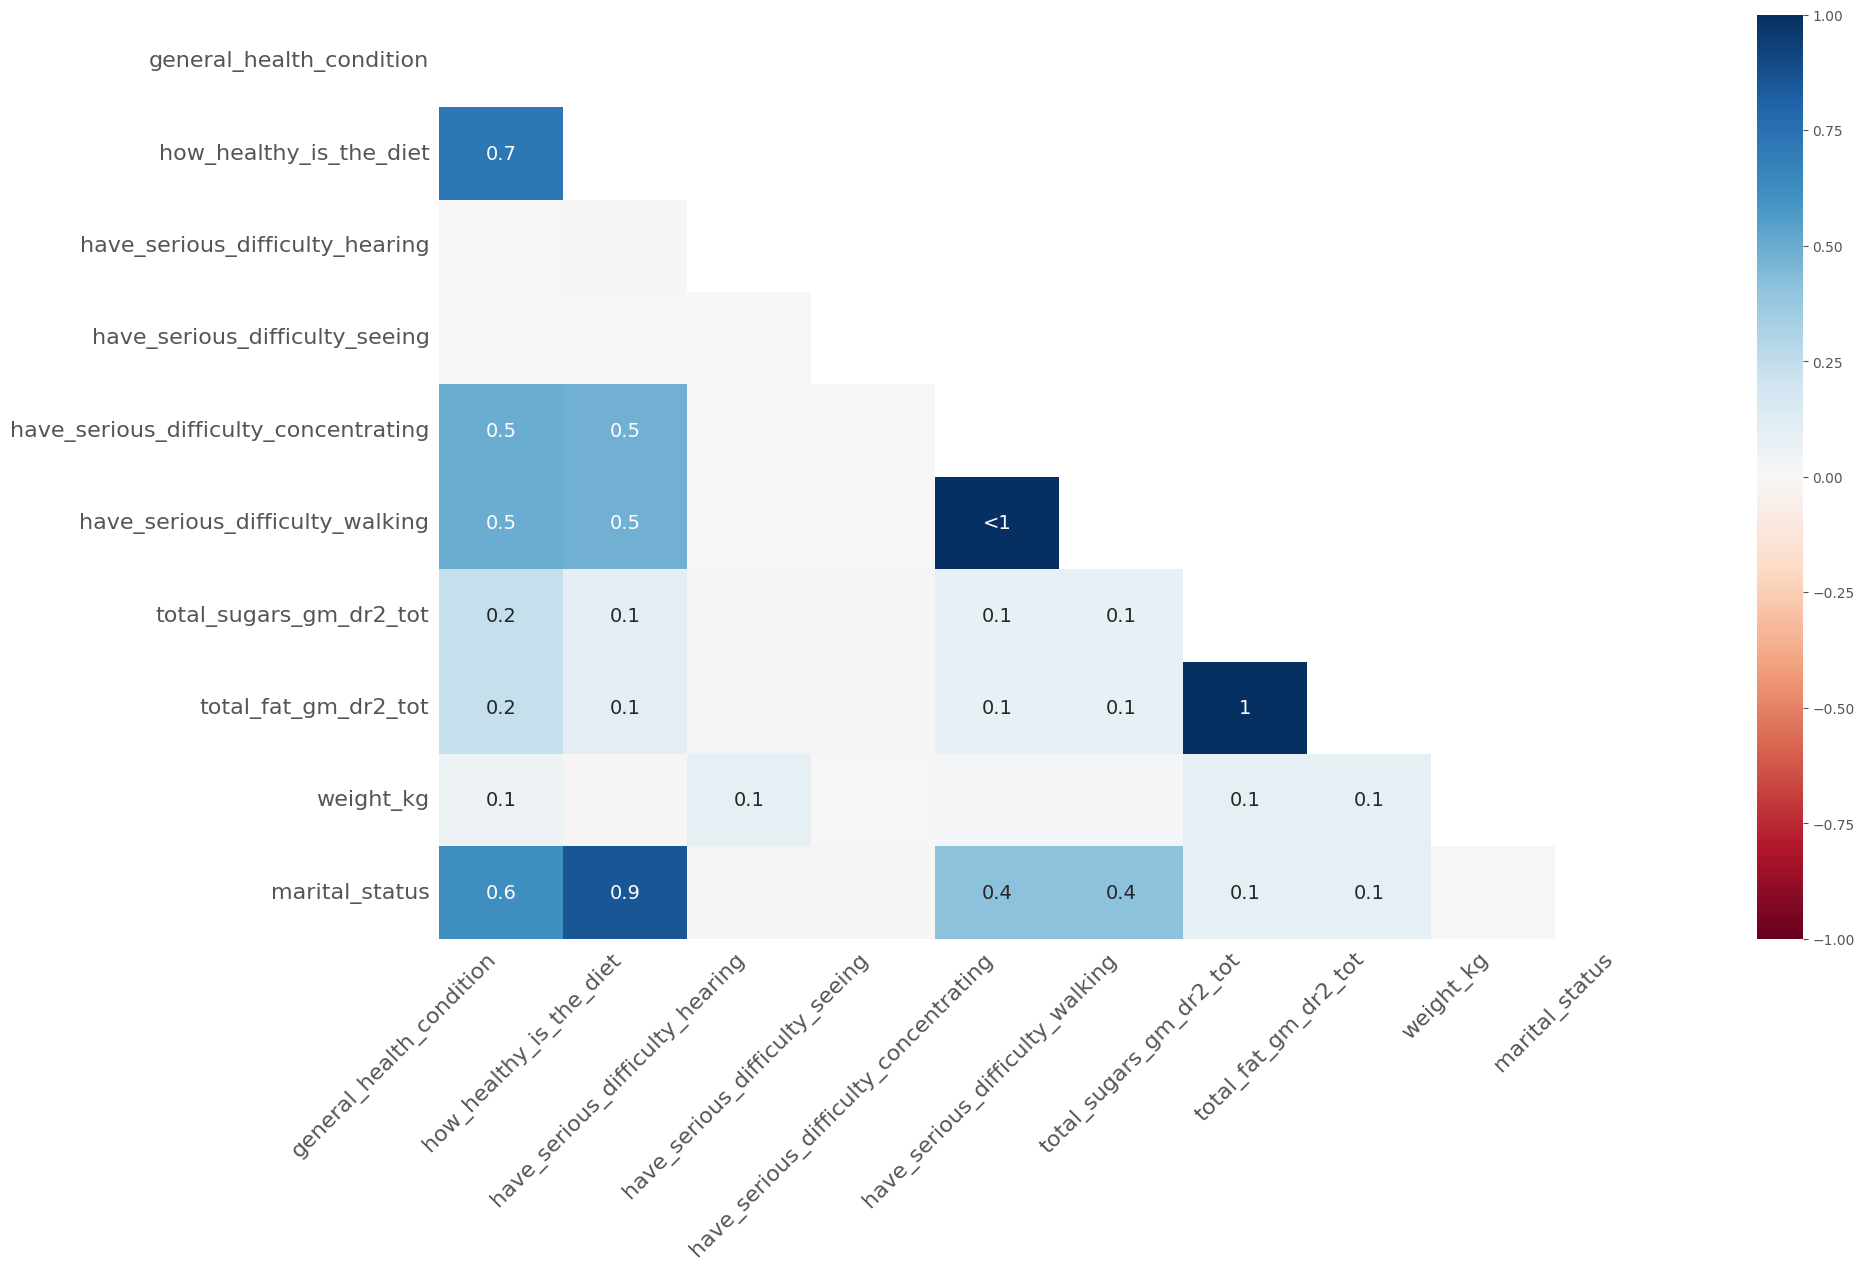

In [ ]:
missingno.heatmap(nhanes_selected)
plt.show()

#3. Entender el tipo de dato nulo por variable

- Los datos son MCAR con la prueba de little validando el p-value

- Son MAR si existen variables relacionadas con mayor completitud, que me permitan estimar esos valores (correlación entre variables, no entre nulos)

- Son MNAR si no son MCAR ni MAR, porque no tenemos cómo reconstruir la variable

In [ ]:
#Función para detectar si los datos son MCAR
def little_mcar_test(data, alpha = 0.05):
  data = pd.DataFrame(data)
  data.columns = ['x' + str(i) for i in range(data.shape[1])]
  data['missing'] = np.sum(data.isnull(), axis = 1)
  n = data.shape[0]
  k = data.shape[1]
  df = k * (k - 1) / 2
  chi2_crit = chi2.ppf(1 - alpha, df)
  chi2_val = ((n - 1 - (k - 1) / 2) ** 2) / (k - 1) / ((n - k) * np.mean(data['missing']))
  p_val = 1 - chi2.cdf(chi2_val, df)
  if chi2_val > chi2_crit:
    print('Se rechaza la hipótesis nula : los datos no son MCAR (p-value = {:.4f}, chi2 = {:.4f})'.format(p_val, chi2_val))
  else:
    print('No se rechaza la hipótesis nula : Los datos son MCAR (p-value = {:.4f}, chi2 = {.4f})'.format(p_val, chi2_val))

In [ ]:
nhanes_test = nhanes_selected.copy()
little_mcar_test(nhanes_test)

Se rechaza la hipótesis nula : los datos no son MCAR (p-value = 0.0000, chi2 = 422.6556)


In [ ]:
missing_values = nhanes_selected.isnull()
little_mcar_test = np.nanmean(missing_values.mean(axis = 1))
little_mcar_test
#Si el resultado es cercano a 0, es probable que los datos sean MAR

0.13744123037692246

## Transformación de variables categoricas para imputación y correlaciones

In [ ]:
set_config('diagram')
categorical_columns = nhanes_selected.select_dtypes(include = 'object').columns
categorical_transformer = sklearn.compose.make_column_transformer((sklearn.preprocessing.OrdinalEncoder(),
                                                                   categorical_columns), remainder='passthrough')
categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'how_healthy_is_the_diet',
       'have_serious_difficulty_hearing', 'have_serious_difficulty_seeing',
       'have_serious_difficulty_concentrating',
       'have_serious_difficulty_walking', 'gender', 'marital_status'],
      dtype='object'))])

In [ ]:
nhanes_transformed_df = pd.DataFrame(categorical_transformer.fit_transform(nhanes_selected),
                                     columns = categorical_transformer.get_feature_names_out(),
                                     index = nhanes_selected.index).rename_columns(function = lambda x: x.removeprefix('ordinalencoder__')).rename_columns(function = lambda x: x.removeprefix('remainder__'))
nhanes_transformed_df

,general_health_condition,how_healthy_is_the_diet,have_serious_difficulty_hearing,have_serious_difficulty_seeing,have_serious_difficulty_concentrating,have_serious_difficulty_walking,gender,marital_status,total_sugars_gm_dr2_tot,total_fat_gm_dr2_tot,weight_kg,age_in_years_at_screening
SEQN,,,,,,,,,,,,
93703.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,13.7,2.0
93704.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN,134.37,37.02,13.9,2.0
93705.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,43.04,55.19,79.5,66.0
93706.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,66.3,18.0
93707.0,2.0,NaN,0.0,0.0,0.0,0.0,1.0,NaN,85.81,93.98,45.4,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,52.84,23.35,49.0,70.0
102953.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,NaN,97.4,42.0
102954.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,87.58,84.05,69.1,41.0


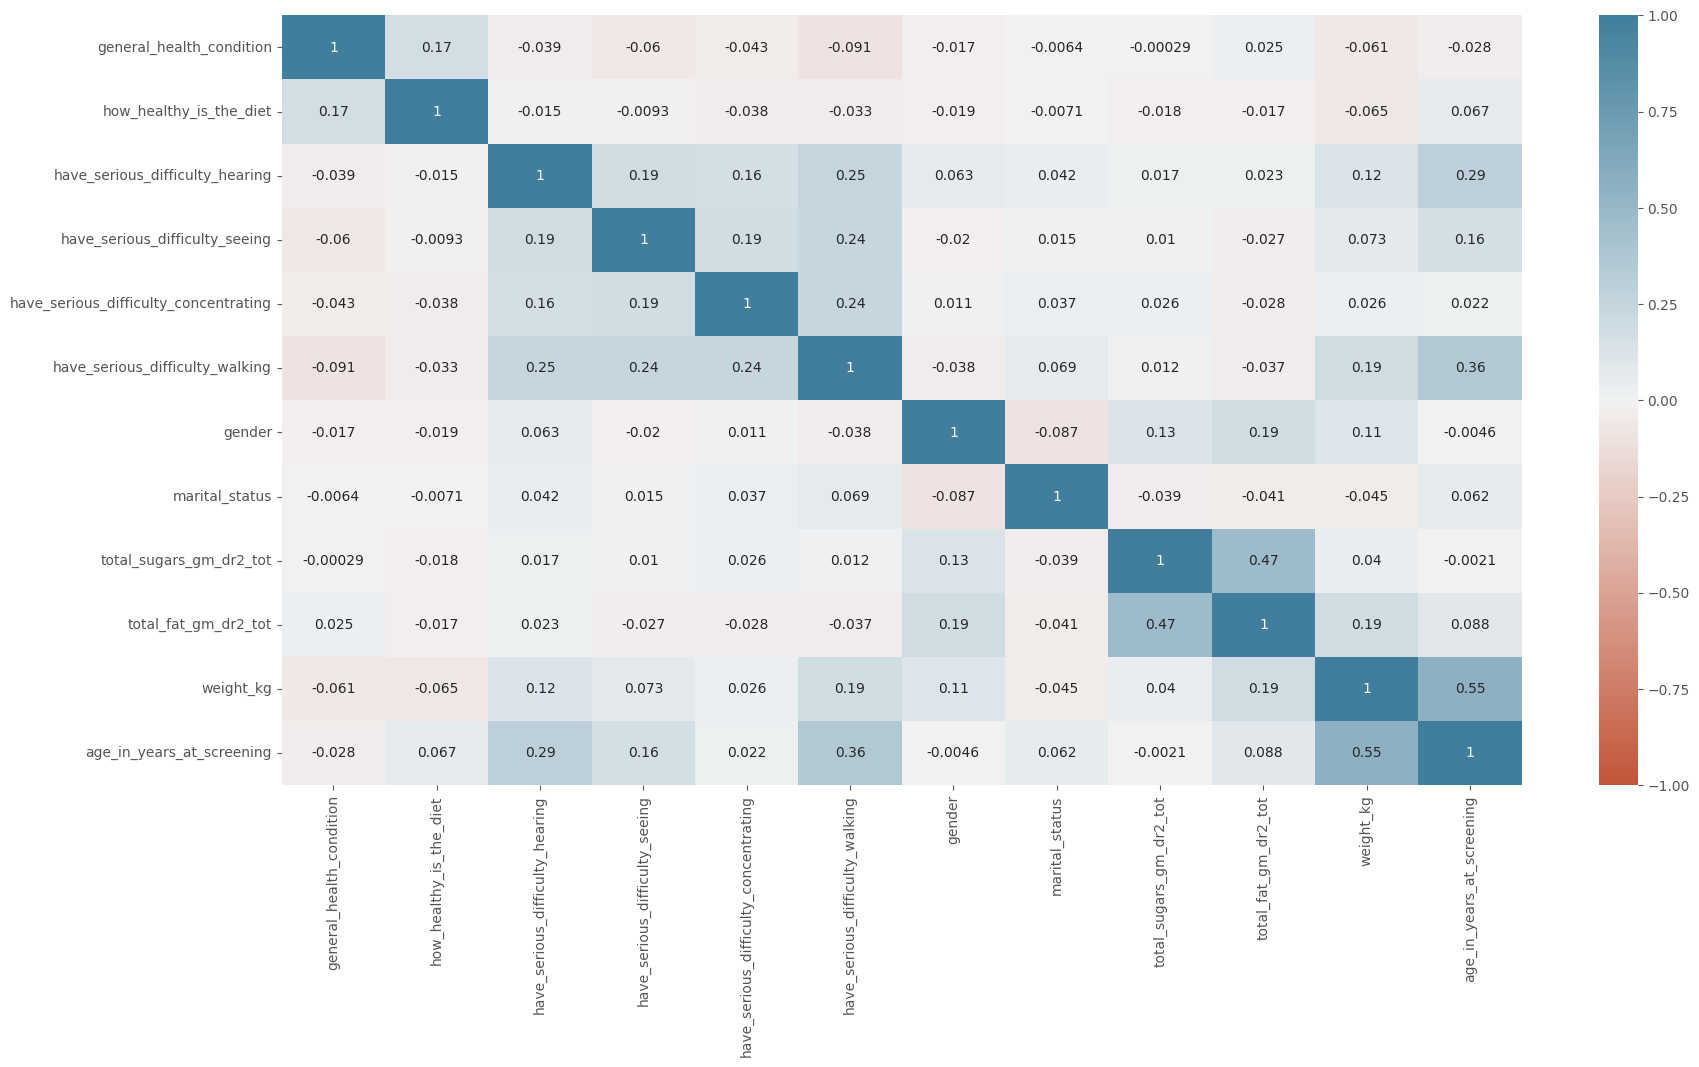

In [ ]:
plt.figure(figsize=(20,10))
sb.heatmap(data = nhanes_transformed_df.corr(numeric_only=True), center = 0,
           vmax=1, vmin=-1, annot=True, cmap = sb.diverging_palette(20,230, as_cmap=True))
plt.show()

Nos basaremos en la siguiente tabla para definir los datos MAR. Estos serán aquellos que tengan una relación moderada o fuerte con otro dato.

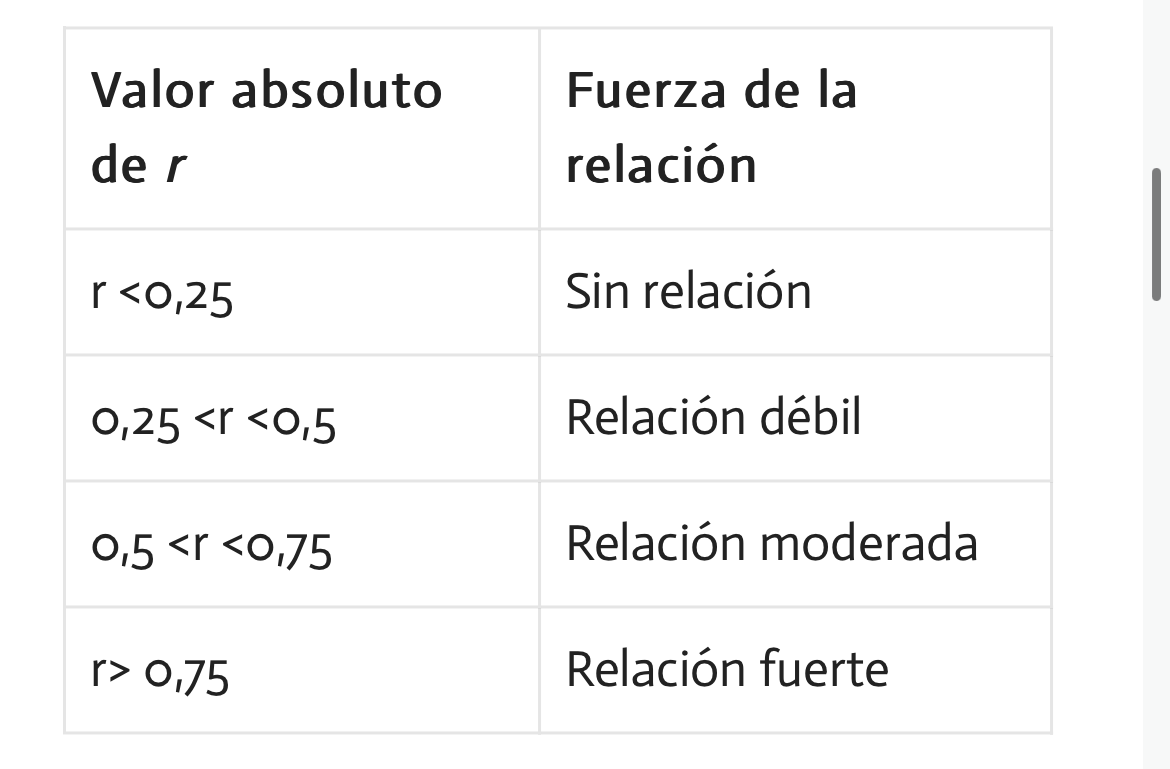

Las únicas variables que cumplen este criterio son weight_kg y age_in_years_at_screening. Lo cual es esperable, ya que a mayor edad mayor peso (hasta llegar a la adultez) por lo general.

## Clasificación de variables:

- general_health_condition: MNAR
- how_healthy_is_the_diet: MNAR
- have_serious_difficulty_hearing: MNAR.
- have_serious_difficulty_seeing: MNAR.
- have_serious_difficulty_concentrating: MNAR
- have_serious_difficulty_walking: MNAR
- total_sugars_gm_dr2_tot: MNAR
- total_fat_gm_dr2_tot: MNAR
- weight_kg: MAR
- gender: No hay datos nulos.
- age_in_years_at_screening: No hay datos nulos.
- marital_status: MNAR


# 4. Decidir qué hacer con cada campo nulo

Nuestro dataset actualmente es así:

In [ ]:
nhanes_selected.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8366 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   general_health_condition               5964 non-null   object 
 1   how_healthy_is_the_diet                5826 non-null   object 
 2   have_serious_difficulty_hearing        8365 non-null   object 
 3   have_serious_difficulty_seeing         8365 non-null   object 
 4   have_serious_difficulty_concentrating  7595 non-null   object 
 5   have_serious_difficulty_walking        7599 non-null   object 
 6   total_sugars_gm_dr2_tot                6323 non-null   float64
 7   total_fat_gm_dr2_tot                   6323 non-null   float64
 8   weight_kg                              8242 non-null   float64
 9   gender                                 8366 non-null   object 
 10  age_in_years_at_screening              8366 non-null   float

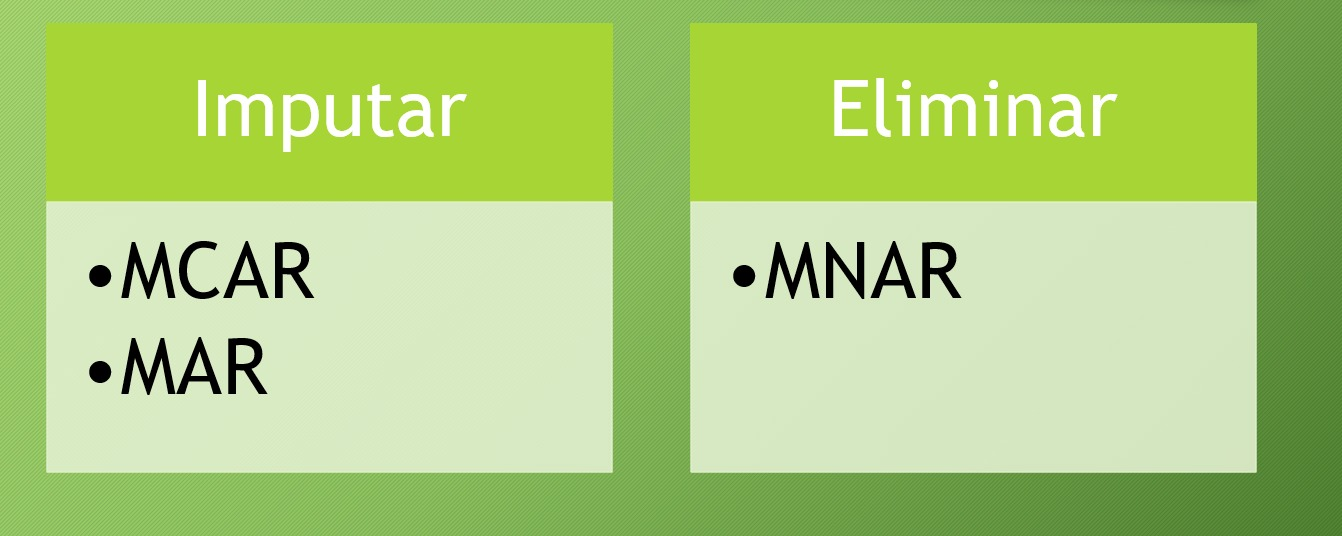

## Variables MNAR

Estas serán eliminadas ya que no pueden ser imputadas. Serán eliminados todos los registros con alguna de estas variables nulas.

In [ ]:
nhanes_drop_df = nhanes_transformed_df.dropna(subset = [
    'general_health_condition',
    'how_healthy_is_the_diet',
    'have_serious_difficulty_hearing',
    'have_serious_difficulty_seeing',
    'have_serious_difficulty_concentrating',
    'have_serious_difficulty_walking',
    'total_sugars_gm_dr2_tot',
    'total_fat_gm_dr2_tot',
    'marital_status'
    ], how='any')
nhanes_drop_df.shape

(4019, 12)

## Variables MAR

Nuestra única variable MAR es 'weight_kg'. Está será imputada mediante el método de KNN.

Escogimos este metodo de imputación debido a su flexibilidad con cualquier tipo de dato, y a que no nos importa el rendimiento computacional en este caso especifico.

In [ ]:
knn_imputer = sklearn.impute.KNNImputer()
nhanes_knn_df = pd.DataFrame(knn_imputer.fit_transform(nhanes_drop_df).round(),
                             columns = nhanes_drop_df.columns,
                             index = nhanes_drop_df.index)
nhanes_knn_df.isnull().any()

general_health_condition                 False
how_healthy_is_the_diet                  False
have_serious_difficulty_hearing          False
have_serious_difficulty_seeing           False
have_serious_difficulty_concentrating    False
have_serious_difficulty_walking          False
gender                                   False
marital_status                           False
total_sugars_gm_dr2_tot                  False
total_fat_gm_dr2_tot                     False
weight_kg                                False
age_in_years_at_screening                False
dtype: bool

# 5. Conjunto de datos final

In [ ]:
nhanes_imputed_df = nhanes_knn_df.copy()
nhanes_imputed_df[categorical_columns] = (categorical_transformer.named_transformers_
                                          .ordinalencoder
                                          .inverse_transform(X = nhanes_knn_df[categorical_columns]))
nhanes_imputed_df.isnull().sum()

general_health_condition                 0
how_healthy_is_the_diet                  0
have_serious_difficulty_hearing          0
have_serious_difficulty_seeing           0
have_serious_difficulty_concentrating    0
have_serious_difficulty_walking          0
gender                                   0
marital_status                           0
total_sugars_gm_dr2_tot                  0
total_fat_gm_dr2_tot                     0
weight_kg                                0
age_in_years_at_screening                0
dtype: int64

nhanes_imputed_df será nuestro dataframe final, el cual no cuenta con datos nulos.

In [ ]:
nhanes_imputed_df

,general_health_condition,how_healthy_is_the_diet,have_serious_difficulty_hearing,have_serious_difficulty_seeing,have_serious_difficulty_concentrating,have_serious_difficulty_walking,gender,marital_status,total_sugars_gm_dr2_tot,total_fat_gm_dr2_tot,weight_kg,age_in_years_at_screening
SEQN,,,,,,,,,,,,
93705.0,Good,Good,0.0,0.0,0.0,0.0,Female,Divorced,43.0,55.0,80.0,66.0
93708.0,Good,Excellent,0.0,0.0,0.0,0.0,Female,Married,42.0,42.0,54.0,66.0
93711.0,Very good,Very good,0.0,0.0,0.0,0.0,Male,Married,164.0,110.0,62.0,56.0
93713.0,Very good,Fair,0.0,0.0,1.0,0.0,Male,Divorced,239.0,60.0,75.0,67.0
93714.0,Good,Fair,0.0,0.0,0.0,0.0,Female,Married,28.0,65.0,87.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102944.0,Excellent,Very good,0.0,0.0,0.0,0.0,Male,Married,48.0,24.0,79.0,55.0
102947.0,Good,Very good,1.0,0.0,0.0,0.0,Male,Divorced,59.0,85.0,73.0,75.0
102952.0,Very good,Excellent,0.0,0.0,0.0,0.0,Female,Married,53.0,23.0,49.0,70.0


In [ ]:
nhanes_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4019 entries, 93705.0 to 102956.0
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   general_health_condition               4019 non-null   object 
 1   how_healthy_is_the_diet                4019 non-null   object 
 2   have_serious_difficulty_hearing        4019 non-null   object 
 3   have_serious_difficulty_seeing         4019 non-null   object 
 4   have_serious_difficulty_concentrating  4019 non-null   object 
 5   have_serious_difficulty_walking        4019 non-null   object 
 6   gender                                 4019 non-null   object 
 7   marital_status                         4019 non-null   object 
 8   total_sugars_gm_dr2_tot                4019 non-null   float64
 9   total_fat_gm_dr2_tot                   4019 non-null   float64
 10  weight_kg                              4019 non-null   float